In [5]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

In [6]:
# Offline changepoint detection
def changepoint_detection(data, hazard_function, distribution):
    length = len(data)
    H = hazard_function(np.arange(length + 1))
    Pr = np.zeros((length + 1, length + 1))    # length + 1 b/c 0 is for priors
    # Pr[r, t] = P(r_t=r, x_1:t)

    Pr[0, 0] = 1
    for t, x in enumerate(data):
        t += 1    # t=0 is for priors stuff. First data point is @ t=1
        predprobs = distribution.pdf(x)
        Pr[1:t + 1, t] = Pr[:t, t - 1] * predprobs * (1 - H[:t])
        Pr[0, t] = np.sum(Pr[:t, t - 1] * predprobs * H[:t])
        Pr[:, t] /= np.sum(Pr[:, t])    # normalize probabilities
        distribution.update(x)
    return Pr

Ideally, we distribution should be anything implenting the following interface:

```Python
class Distribution(object):
    self.params = ...
    def pdf(self, data):
        """ eval pdf @ data"""
    def update(self, data):
        """ Bayesian update self.params based on data """
```

This way, our online changepoint detector won't have to worry about the details of the Bayesian inference. Looking into PyMC for this

In [7]:
class StudentT(object):
    """ Taken from https://github.com/hildensia/bayesian_changepoint_detection.    
    """
    def __init__(self, alpha, beta, kappa, mu):
        self.alpha0 = self.alpha = np.array([alpha])
        self.beta0 = self.beta = np.array([beta])
        self.kappa0 = self.kappa = np.array([kappa])
        self.mu0 = self.mu = np.array([mu])

    def pdf(self, data):
        return stats.t.pdf(x=data, 
                           df=2*self.alpha,
                           loc=self.mu,
                           scale=np.sqrt(self.beta * (self.kappa+1) / (self.alpha *
                               self.kappa)))

    def update(self, data):
        muT0 = np.concatenate((self.mu0, (self.kappa * self.mu + data) / (self.kappa + 1)))
        kappaT0 = np.concatenate((self.kappa0, self.kappa + 1.))
        alphaT0 = np.concatenate((self.alpha0, self.alpha + 0.5))
        betaT0 = np.concatenate((self.beta0, self.beta + (self.kappa * (data -
            self.mu)**2) / (2. * (self.kappa + 1.))))
            
        self.mu = muT0
        self.kappa = kappaT0
        self.alpha = alphaT0
        self.beta = betaT0

In [8]:
data = [0] * 100 + [1] * 100
def hazard(t):
    # given run length, return Pr(run is over)
    p = 0.6
    return p * (1-p) ** t
R1 = changepoint_detection(data, hazard, StudentT(0.1, 0.1, 1, 0))

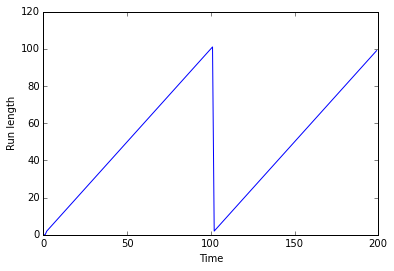

In [11]:
plt.plot([R1[:, t].argmax() for t in range(len(data))])
plt.xlabel("Time")
plt.ylabel("Run length")
plt.show()

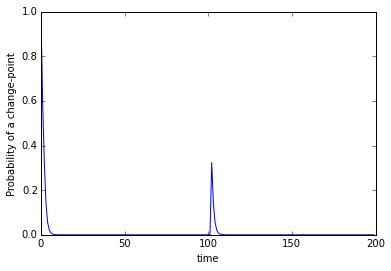

In [12]:
plt.plot([R1[0, t] for t in range(len(data))])
plt.xlabel("time")
plt.ylabel("Probability of a change-point")
plt.show()